# Detector de Clickbait

## Carga de librerias y datos

In [1]:
import pandas as pd
import torch
import torch.optim as optim
from torch.optim import lr_scheduler

import matplotlib.pyplot as plt
import numpy as np

from wordcloud import WordCloud

import nltk
import re
import string

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer

import gensim

nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")

stopwords_en = stopwords.words("english")
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer("english")
punctuation = string.punctuation


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [2]:
%matplotlib inline

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
!pip3 install transformers

     |████████████████████████████████| 3.8 MB 4.1 MB/s 
     |████████████████████████████████| 6.5 MB 15.7 MB/s 
     |████████████████████████████████| 596 kB 10.5 MB/s 
     |████████████████████████████████| 895 kB 34.9 MB/s 
     |████████████████████████████████| 77 kB 3.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
def normalize_doc(doc):
  normalized_doc = []
  for token in nltk.word_tokenize(doc):
      token = re.sub(r'[^a-zA-Z0-9\s]+', '', token)
      token = token.lower()
      token = lemmatizer.lemmatize(token)
      if (token not in stopwords_en) and (token not in punctuation) and (len(token) > 3):
        normalized_doc.append(token)
  return ' '.join(normalized_doc)

In [8]:
df_train = pd.read_csv('/content/drive/MyDrive/Newtral/webis_train.csv')
df_train.dropna(axis = 'index', inplace=True)
df_train['targetParagraphs_join'] = df_train['targetParagraphs'].apply(lambda x: normalize_doc(x))
df_train['postText_join'] = df_train['postText'].apply(lambda x: normalize_doc(x))
df_train['label'] = df_train['truthClass'].apply(lambda x: 0 if x == 'no-clickbait' else 1)
train_labels = np.array(df_train['label'])

df_test = pd.read_csv('/content/drive/MyDrive/Newtral/webis_test.csv')
df_test.dropna(axis = 'index', inplace=True)
df_test['targetParagraphs_join'] = df_test['targetParagraphs'].apply(lambda x: normalize_doc(x))
df_test['postText_join'] = df_test['postText'].apply(lambda x: normalize_doc(x))
df_test['label'] = df_test['truthClass'].apply(lambda x: 0 if x == 'no-clickbait' else 1)
test_labels = np.array(df_test['label'])



num_labels = df_train['truthClass'].nunique()

In [ ]:
num_labels

In [ ]:
df_train.head(2)

## 1. Análisis descriptivo de los datos

### Distribución de clickbait en los datos de train y test

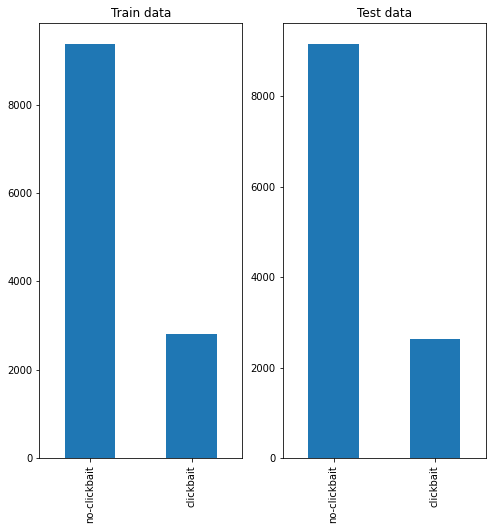

In [ ]:
plt.figure(figsize=(8,8))

plt.subplot(1,2,1).title.set_text('Train data')
df_train['truthClass'].value_counts().plot(kind = 'bar')
plt.subplot(1,2,2).title.set_text('Test data')
df_test['truthClass'].value_counts().plot(kind = 'bar')

plt.show()

In [ ]:
df_train.dtypes

Unnamed: 0                 int64
postMedia                 object
postText                  object
id                         int64
targetCaptions            object
targetParagraphs          object
targetTitle               object
postTimestamp             object
targetKeywords            object
targetDescription         object
truthJudgments            object
truthMean                float64
truthClass                object
truthMedian              float64
truthMode                float64
targetParagraphs_join     object
label                      int64
dtype: object

Podemos ver como las distribuciones entre clickbait y no clickbait son identicas para ambos sets de datos (train y test). En ambos casos nos encontramos antre datos desbalanceados (el número de ejemplos de una clase es muy diferente del número de ejemplos pertenecientes a la clase opuesta).

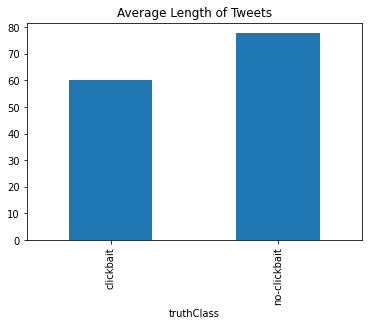

In [ ]:
df_train['tweet_length'] = df_train['postText'].str.len()

grouped_train_df = df_train.groupby(['truthClass'])
grouped_train_df.mean()['tweet_length'].plot(kind='bar',title = 'Average Length of Tweets')
plt.show()

Podemos ver también como aquellos tweets clasificados como clickbait son, en media, 20 caracteres mas largos que aquellos que no lo son. Podemos entenderlo como algo lógico ya que, a menos información, mayores son las posibilidades abiertas en la mente del lector. 

Si un tweet expone la información suficiente, las opciones de que haya clickbait se reducen.

### Análisis de los términos

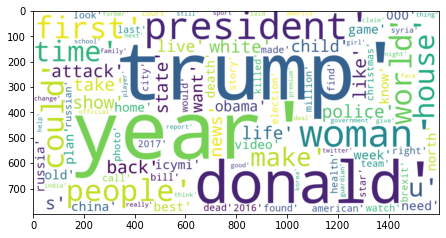

In [ ]:
tweets = df_train.postText.tolist()

words = []

for tweet in tweets:
  for word in nltk.word_tokenize(normalize_doc(tweet)):
    words.append(word)

most_common_words = nltk.probability.FreqDist(words).most_common(100)

wc = WordCloud(width = 1600, height = 800, background_color = 'white').generate(str(most_common_words))

plt.imshow(wc,interpolation='bilinear')
plt.tight_layout(pad = 0)
plt.show()

En el anterior wordcloud podemos visualizar las palabras mas importantes del training set. No obstante, sería interesante visualizar las 100 palabras mas importantes para cada una de las clases. Lo hacemos en la siguiente celda.

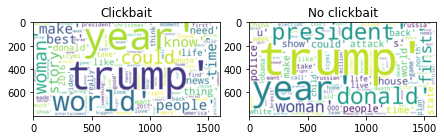

In [ ]:
df_clickbait = df_train[df_train['truthClass'] == 'clickbait']
df_no_clickbait = df_train[df_train['truthClass'] == 'no-clickbait']

tweets_clickbait = df_clickbait.postText.tolist()
tweets_no_clickbait = df_no_clickbait.postText.tolist()

words_clickbait = []
words_no_clickbait = []

for tweet in tweets_clickbait:
  for word in nltk.word_tokenize(normalize_doc(tweet)):
    words_clickbait.append(word)

for tweet in tweets_no_clickbait:
  for word in nltk.word_tokenize(normalize_doc(tweet)):
    words_no_clickbait.append(word)

most_common_words_clickbait = nltk.probability.FreqDist(words_clickbait).most_common(100)
most_common_words_no_clickbait = nltk.probability.FreqDist(words_no_clickbait).most_common(100)


wc_clickbait = WordCloud(width = 1600, height = 800, background_color = 'white').generate(str(most_common_words_clickbait))
wc_no_clickbait = WordCloud(width = 1600, height = 800, background_color = 'white').generate(str(most_common_words_no_clickbait))

plt.subplot(1,2,1).title.set_text('Clickbait')
plt.imshow(wc_clickbait,interpolation='bilinear')
plt.subplot(1,2,2).title.set_text('No clickbait')
plt.imshow(wc_no_clickbait,interpolation='bilinear')
plt.tight_layout(pad = 0)
plt.show()

[]

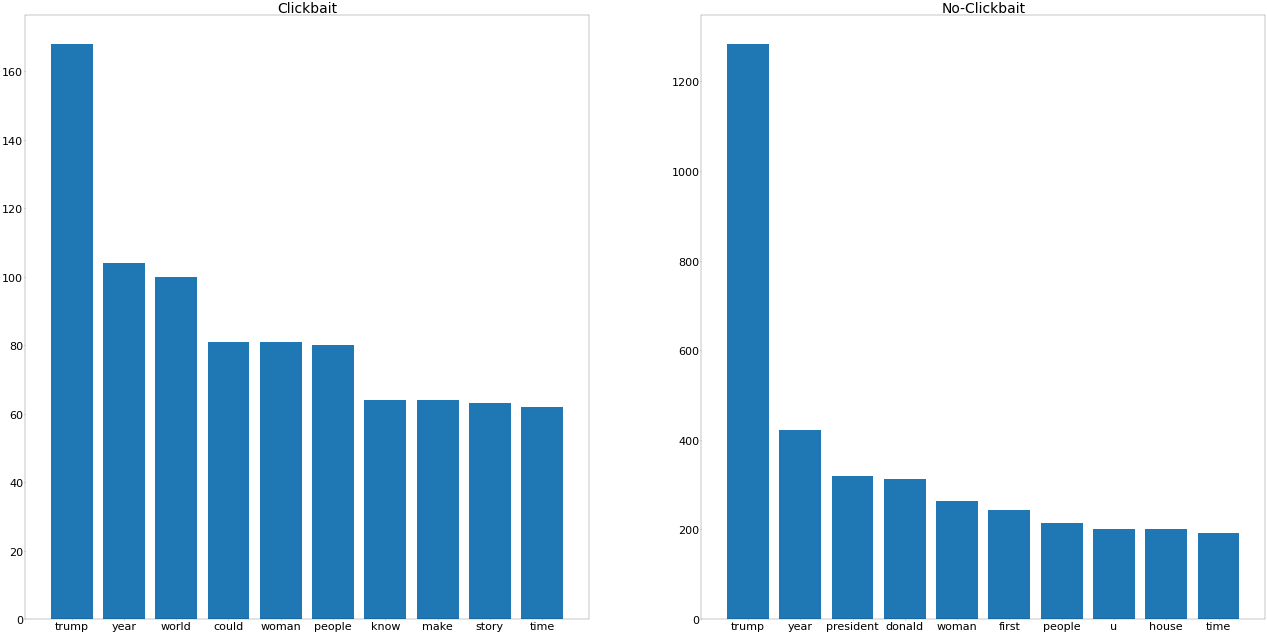

In [ ]:
mcw_cb_10 = nltk.probability.FreqDist(words_clickbait).most_common(10)
x_cb_10,y_cb_10 = zip(*mcw_cb_10)
mcw_ncb_10 = nltk.probability.FreqDist(words_no_clickbait).most_common(10)
x_ncb_10,y_ncb_10 = zip(*mcw_ncb_10)

plt.figure(figsize=(80,40),dpi = 20)

plt.subplot(1,2,1).set_title('Clickbait', size = 50)
plt.bar(x_cb_10,y_cb_10)
plt.xticks(fontsize = 40)
plt.yticks(fontsize = 40)

plt.subplot(1,2,2).set_title('No-Clickbait', size = 50)
plt.bar(x_ncb_10,y_ncb_10)
plt.xticks(fontsize = 40)
plt.yticks(fontsize = 40)

plt.plot()

Algo importante de lo que darse cuenta es de las frecuencias, mucho mayores en el caso de no-clickbait. Esto puede deberse a que en el caso de clickbait tenemos una mayor variedad de palabras y por lo tanto la frecuencia queda mucho más dispersa.

### Análisis de tópicos

Para realizar el analisis de tópicos, a diferencia de los casos anteriores, utilizaremos los párrafos objetivo.

In [ ]:
paragraphs = df_train.targetParagraphs.tolist()

paragraphs_normalized = []

for paragraph in paragraphs:
  paragraphs_normalized.append(normalize_doc(paragraph).split(' '))

In [ ]:
paragraphs_normalized[:2]

In [ ]:
D = gensim.corpora.Dictionary(paragraphs_normalized)
n_tokens = len(D)
n_tokens

147260

Refinamos el diccionario para reducir la complejidad. Aquellos documentos presentes en menos de 20 tweets serán demasiado específicos para que podamos aprender de ellos. Aquellos que esten por encima del 80% serán muy generales para proveer informacion distintiva a la hora de diferenciar tópicos.

In [ ]:
D.filter_extremes(no_below = 20, no_above = 0.8)
n_tokens = len(D)
n_tokens

12608

In [ ]:
paragraph_bow = [D.doc2bow(paragraph) for paragraph in paragraphs_normalized]

Entrenamos un modelo de Latent Discriminant Allocation que nos permita obtener las palabras más relevantes de entre n tópicos.

In [ ]:
num_topics = 10
lda_model = gensim.models.LdaMulticore(paragraph_bow, num_topics  = num_topics, id2word = D, passes = 5)

Mostramos las palabras mas relevantes para cada tópico

In [ ]:
for idx,topic in lda_model.print_topics():
  print("Topico ",idx,": \nPalabras: ",topic)

Topico  0 : 
Palabras:  0.024*"said" + 0.009*"attack" + 0.009*"police" + 0.006*"people" + 0.006*"state" + 0.005*"country" + 0.005*"minister" + 0.005*"syria" + 0.005*"russia" + 0.004*"killed"
Topico  1 : 
Palabras:  0.010*"woman" + 0.007*"people" + 0.007*"like" + 0.005*"time" + 0.005*"year" + 0.005*"life" + 0.005*"show" + 0.005*"book" + 0.004*"story" + 0.004*"also"
Topico  2 : 
Palabras:  0.041*"trump" + 0.014*"president" + 0.012*"said" + 0.010*"breitbart" + 0.008*"donald" + 0.007*"election" + 0.007*"campaign" + 0.007*"obama" + 0.007*"news" + 0.005*"white"
Topico  3 : 
Palabras:  0.013*"game" + 0.012*"team" + 0.010*"season" + 0.008*"year" + 0.007*"player" + 0.006*"last" + 0.005*"would" + 0.005*"league" + 0.005*"first" + 0.005*"week"
Topico  4 : 
Palabras:  0.022*"said" + 0.008*"police" + 0.006*"court" + 0.006*"state" + 0.006*"case" + 0.005*"people" + 0.005*"told" + 0.005*"woman" + 0.005*"year" + 0.004*"would"
Topico  5 : 
Palabras:  0.009*"like" + 0.008*"time" + 0.008*"game" + 0.008*"sa

A continuación escribo los resultados del modelo LDA utilizados para realizar el análisis de tópicos ya que los resultados pueden cambiar entre diversas ejecuciones.

**Tópico**  0 :

Palabras:  0.024*"said" + 0.009*"attack" + 0.009*"police" + 0.006*"people" + 0.006*"state" + 0.005*"country" + 0.005*"minister" + 0.005*"syria" + 0.005*"russia" + 0.004*"killed"

**Tópico**  1 :

Palabras:  0.010*"woman" + 0.007*"people" + 0.007*"like" + 0.005*"time" + 0.005*"year" + 0.005*"life" + 0.005*"show" + 0.005*"book" + 0.004*"story" + 0.004*"also"

**Tópico**  2 :

Palabras:  0.041*"trump" + 0.014*"president" + 0.012*"said" + 0.010*"breitbart" + 0.008*"donald" + 0.007*"election" + 0.007*"campaign" + 0.007*"obama" + 0.007*"news" + 0.005*"white"

**Tópico**  3 : 

Palabras:  0.013*"game" + 0.012*"team" + 0.010*"season" + 0.008*"year" + 0.007*"player" + 0.006*"last" + 0.005*"would" + 0.005*"league" + 0.005*"first" + 0.005*"week"

**Tópico**  4 : 

Palabras:  0.022*"said" + 0.008*"police" + 0.006*"court" + 0.006*"state" + 0.006*"case" + 0.005*"people" + 0.005*"told" + 0.005*"woman" + 0.005*"year" + 0.004*"would"

**Tópico**  5 : 

Palabras:  0.009*"like" + 0.008*"time" + 0.008*"game" + 0.008*"said" + 0.006*"year" + 0.006*"know" + 0.006*"point" + 0.006*"going" + 0.005*"thing" + 0.005*"team"

**Tópico**  6 : 

Palabras:  0.013*"said" + 0.008*"north" + 0.006*"flight" + 0.006*"also" + 0.006*"would" + 0.005*"korea" + 0.005*"film" + 0.005*"plane" + 0.004*"year" + 0.004*"image"

**Tópico**  7 : 

Palabras:  0.013*"said" + 0.013*"year" + 0.012*"company" + 0.006*"percent" + 0.005*"market" + 0.004*"government" + 0.004*"billion" + 0.004*"also" + 0.004*"million" + 0.004*"last"

**Tópico**  8 : 

Palabras:  0.015*"said" + 0.012*"would" + 0.007*"state" + 0.007*"republican" + 0.006*"health" + 0.006*"trump" + 0.006*"people" + 0.006*"school" + 0.006*"year" + 0.005*"government"

**Tópico**  9 : 

Palabras:  0.012*"said" + 0.008*"people" + 0.006*"year" + 0.005*"time" + 0.005*"child" + 0.005*"like" + 0.004*"also" + 0.004*"city" + 0.004*"found" + 0.004*"could"


Podemos observar cosas muy interesantes como por ejemplo la importancia de la palabra "said" en todos ellos. Esto puede deberse a que la mayoría de noticias objeto de este estudio involucran referencias a declaraciones de terceros. 

Como es logico al analizar los tópicos de un LDA, obtenemos algunos mas interpretables y otros que lo son menos.



*   Tópico 0: Palabras como "attack", "killed", "police" o "russia". Puede referirse a noticias relativas a hechos violentos. Son conocidos los numerosos casos de agresiones policiales en EEUU así como la actual situación de conflicto en paises como Rusia o Siria. Podriamos denominar al tópico 0 como **VIOLENCE**.
*   Tópico 1: Palabras como "life", "time", "show", "book" o "story". Palabras relacionadas con actividades culturales y recreativas. Podríamos denominar al tópico 1 como **LEISURE**.
*   Tópico 2: Palabras como "trump", "election", "campaing", "obama", "news" o "breitbart". Claramente todas ellas relacionadas con el mundo de la política. Podriamos usar la denominación **POLITICS**.
*   Tópicos 3 y 5: Palabras como "game", "team", "season" o "player". Evidentemente, a los tópico 3 y 5 les correspondería la "etiqueta" de **SPORTS**.
*    Tópico 4: Palabras como "court", "state" o "case" podrían estar relacionadas con casos judiciales. Lo denominaremos **LEGAL**.
*    Tópico 6: Quizá el tópico menos interpretable. Palabras como "north", "plane", "korea" o "flight" podría hacernos pensar que se trata de noticias relacionadas con el régimen norcoreano y su conflictividad con muchos de los paises occidentales. No obstante, aparece la palabra "film" por lo que tambien podría incluir noticias acerca del cine surcoreano que está muy al alza en los últimos años. Puede que la presencia de "north" y "korea" entre las palabras mas importantes asemejen más este tópico a la primera opción. No obstante, en caso de duda optaré por no "etiquetar" este tópico.  
*    Tópico 7: "company", "market", "billion" o "million" son términos claramente sesgados hacia el campo de la economía. **ECONOMY**.
*    Tópicos 8 y 9: Al ser palabras como "health", "school", "child" o "city" importantes en estos tópicos podriamos etiquetarlos como **SOCIAL**. 

Podemos ver que las noticias incluidas en el dataset tratan la mayoría de temas de interés de la sociedad. Por ello, en caso de obtener un buen modelo de predicción de clickbait podríamos aplicarlo a tweets de cualquier naturaleza pues el modelo no estaría sesgado a ningún tópico en particular ya que la mayoría están representados.

## 2. Bert Model

In [40]:
import torch
from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
from transformers import BertTokenizerFast, BertForSequenceClassification
from transformers import Trainer, TrainingArguments

In [41]:
model_name = 'bert-base-uncased'
max_length = 256
tokenizer = BertTokenizerFast.from_pretrained(model_name,do_lower_case=True)

loading file https://huggingface.co/bert-base-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/bert-base-uncased/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/534479488c54aeaf9c3406f647aa2ec13648c06771ffe269edabebd4c412da1d.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4
loading file https://huggingface.co/bert-base-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/c1d7f0a763fb63861cc08553866f1fc3e5a6f4f07621be277452d26d71303b7e.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a

In [42]:
train_encodings = tokenizer(df_train.postText_join.tolist(),truncation=True,padding=True,max_length=max_length)
test_encodings = tokenizer(df_test.postText_join.tolist(),truncation=True,padding=True,max_length=max_length)

In [43]:
class clickbaitDataset(torch.utils.data.Dataset):
  def __init__(self,encodings,labels):
    self.encodings = encodings
    self.labels = labels

  def __getitem__(self,idx): #override this method to access dataset element in a simpler way dataset[i]
    item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
    item["labels"] = torch.tensor([self.labels[idx]])
    return item

  def __len__(self): #override this method so that len method returns the number of "news" in the dataset
    return len(self.labels)


In [44]:
train_dataset = clickbaitDataset(train_encodings,train_labels)
test_dataset = clickbaitDataset(test_encodings,test_labels)

In [45]:
model = BertForSequenceClassification.from_pretrained(model_name,num_labels = num_labels).to(device)

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin from cache 

En cuanto a la metrica respecto a la que elegiremos el mejor modelo, al tratarse de clasificación binaria podemos recurrir a las métricas derivadas de la matriz de confusión. Vamos a considerar dos métricas (consideramos positivo clickbait y negativo no clickbait):

*   Sensibilidad: cuantifica el grado en el que evitamos falsos negativos, es decir, noticias que son clickbait clasificadas como no clickbait. Minimizaremos esta métrica cuando el coste de clasificar un tweet no clickbait como clickbait es menor que el coste de clasificar un tweet clickbait como no clickbait.
*   Especificidad: cuantifica el grado en el que evitamos falsos positivos. En otras palabras, tweets que no son clickbait clasificados como clickbait. 

Vamos a utilizar una métrica u otra dependiendo del uso que pretendamos darle al modelo. En el caso de Newtral, supondré que el objetivo es denunciar a medios que recurren a estas tácticas. Como esta denuncia se hará publicamente, debemos estar muy seguros de que los tweets clasificados como clickbait realmente lo son. Por ello, nos centraremos en evitar falsos positivos y por tanto la métrica a optimizar será especificidad. 



In [46]:
from sklearn.metrics import accuracy_score, confusion_matrix

def compute_specificity(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  tn,fp,fn,tp = confusion_matrix(labels,preds).ravel()
  return tn/(tn+fp)

def compute_precision(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  tn,fp,fn,tp = confusion_matrix(labels,preds).ravel()
  return tp/(tp+fp)


def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  acc = accuracy_score(labels, preds)
  spec = compute_specificity(pred)
  prec = compute_precision(pred)
  return {
      'accuracy': acc,
      'specificity': spec,
      'precision': prec
  }

In [47]:
# Usaremos SGD con momento para optimizar
optimizer_ft = optim.SGD(model.parameters(), lr=0.01, momentum=0.9) 

# Factor de Learning Rate Decay
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=1000, gamma=0.5,verbose=False) #0.5

In [48]:
training_args = TrainingArguments(output_dir = '/content/drive/MyDrive/Trabajo/Entrevistas/Newtral/', 
                                  num_train_epochs = 5, warmup_steps = 100, weight_decay = 0.001, seed = 1333)
trainer = Trainer(model = model, args = training_args, train_dataset = train_dataset, eval_dataset = test_dataset, compute_metrics = compute_metrics, optimizers = (optimizer_ft,exp_lr_scheduler))

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [49]:
trainer.train()
trainer.evaluate()

***** Running training *****
  Num examples = 12202
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7630


Step,Training Loss
500,0.504000
1000,0.495300
1500,0.426200
2000,0.402300
2500,0.394700
3000,0.381800
3500,0.361700
4000,0.353700
4500,0.359700
5000,0.334100


Saving model checkpoint to /content/drive/MyDrive/Trabajo/Entrevistas/Newtral/checkpoint-500
Configuration saved in /content/drive/MyDrive/Trabajo/Entrevistas/Newtral/checkpoint-500/config.json
Model weights saved in /content/drive/MyDrive/Trabajo/Entrevistas/Newtral/checkpoint-500/pytorch_model.bin
Saving model checkpoint to /content/drive/MyDrive/Trabajo/Entrevistas/Newtral/checkpoint-1000
Configuration saved in /content/drive/MyDrive/Trabajo/Entrevistas/Newtral/checkpoint-1000/config.json
Model weights saved in /content/drive/MyDrive/Trabajo/Entrevistas/Newtral/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to /content/drive/MyDrive/Trabajo/Entrevistas/Newtral/checkpoint-1500
Configuration saved in /content/drive/MyDrive/Trabajo/Entrevistas/Newtral/checkpoint-1500/config.json
Model weights saved in /content/drive/MyDrive/Trabajo/Entrevistas/Newtral/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to /content/drive/MyDrive/Trabajo/Entrevistas/Newtral/checkpoint-20

{'epoch': 5.0,
 'eval_accuracy': 0.8436360552870347,
 'eval_loss': 0.40604186058044434,
 'eval_precision': 0.6752098983650022,
 'eval_runtime': 69.0564,
 'eval_samples_per_second': 170.774,
 'eval_specificity': 0.9197247706422018,
 'eval_steps_per_second': 21.359}

### Análisis de errores

El modelo obtenido tiene una especificidad del 93,7%. Esto significa que del total de noticias que no son clickbait, el 93,7% son clasificadas como tal. Por lo tanto, cuando el modelo obtenido clasifica un tweet como no-clickbait podemos tener una gran certeza de que verdaderamente no lo es. Por ello, a la hora de denunciar un tweet como clickbait vamos a poder hacerlo de manera confiada ya que solo un 8% de los tweets no clickbait son mal clasificados.

En cuanto a la accuracy, podemos ver que ésta es del 84%, lo que significa que el 84% de los tweets son clasificados correctamente.

La precision alcanzada en test es de 70,4%. Esto significa que, de todos aquellos tweets que el modelo clasifica como clickbait, el 70,4% son verdaderamente clickbait. Quizá esta es la peor metrica de todas y la que deberíamos centrarnos en mejorar en un caso de uso real.

Finalmente, si atendemos a la loss, podemos ver que en test es del 0.38 mientras que en train alcanzamos 0.36 en el mejor de los casos. Por ello, podemos determinar que el modelo es capaz de generalizar ante nuevos datos nunca vistos. 

